In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -R /content/drive/MyDrive/data

/content/drive/MyDrive/data:
Testing  Training

/content/drive/MyDrive/data/Testing:
glioma	meningioma  notumor  pituitary

/content/drive/MyDrive/data/Testing/glioma:
Te-gl_0010.jpg	Te-gl_0060.jpg	Te-gl_0110.jpg	Te-gl_0160.jpg	Te-gl_0210.jpg	Te-gl_0260.jpg
Te-gl_0011.jpg	Te-gl_0061.jpg	Te-gl_0111.jpg	Te-gl_0161.jpg	Te-gl_0211.jpg	Te-gl_0261.jpg
Te-gl_0012.jpg	Te-gl_0062.jpg	Te-gl_0112.jpg	Te-gl_0162.jpg	Te-gl_0212.jpg	Te-gl_0262.jpg
Te-gl_0013.jpg	Te-gl_0063.jpg	Te-gl_0113.jpg	Te-gl_0163.jpg	Te-gl_0213.jpg	Te-gl_0263.jpg
Te-gl_0014.jpg	Te-gl_0064.jpg	Te-gl_0114.jpg	Te-gl_0164.jpg	Te-gl_0214.jpg	Te-gl_0264.jpg
Te-gl_0015.jpg	Te-gl_0065.jpg	Te-gl_0115.jpg	Te-gl_0165.jpg	Te-gl_0215.jpg	Te-gl_0265.jpg
Te-gl_0016.jpg	Te-gl_0066.jpg	Te-gl_0116.jpg	Te-gl_0166.jpg	Te-gl_0216.jpg	Te-gl_0266.jpg
Te-gl_0017.jpg	Te-gl_0067.jpg	Te-gl_0117.jpg	Te-gl_0167.jpg	Te-gl_0217.jpg	Te-gl_0267.jpg
Te-gl_0018.jpg	Te-gl_0068.jpg	Te-gl_0118.jpg	Te-gl_0168.jpg	Te-gl_0218.jpg	Te-gl_0268.jpg
Te-gl_0019.jpg	Te-gl_0

In [ ]:
# Define your image dimensions
img_height = 224
img_width = 224
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/Training',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'sparse',
    color_mode = 'grayscale'
)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/data/Testing',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'sparse',
    color_mode = 'grayscale'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
def display_images_from_generator(generator, num_classes, num_images_per_class=5):
    plt.figure(figsize=(15, 15))

    # Iterate through each class
    for class_index in range(num_classes):
        class_label = generator.class_indices.keys()
        class_name = list(class_label)[class_index]

        # Get a batch of images and labels from the generator
        images, labels = next(generator)
        class_images = [images[i] for i in range(len(labels)) if labels[i] == class_index]

        # Display num_images_per_class images from this class
        for i in range(min(num_images_per_class, len(class_images))):
            plt.subplot(num_classes, num_images_per_class, class_index * num_images_per_class + i + 1)
            plt.imshow(class_images[i].squeeze(), cmap='gray')  # Use 'gray' colormap for grayscale images
            plt.axis('off')
            if i == 0:
                plt.title(class_name)

    plt.tight_layout()
    plt.show()

In [ ]:
# Number of classes in your dataset
num_classes = len(train_generator.class_indices)

# Display images from the training generator
print("Training Images:")
display_images_from_generator(train_generator, 4)

# Display images from the testing generator
print("Testing Images:")
display_images_from_generator(test_generator, 4)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Get a batch of images from the generator
images, labels = next(train_generator)

# Check the shape of the first image
image_shape = images[0].shape
print(f"Shape of first image: {image_shape}")

# Determine if the image is grayscale or RGB
if len(image_shape) == 3:
    if image_shape[2] == 1:
        print("The images are grayscale (black and white).")
    elif image_shape[2] == 3:
        print("The images are RGB (color).")
else:
    print("Unexpected image shape.")


Shape of first image: (224, 224, 1)
The images are grayscale (black and white).


In [ ]:
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    # It normalizes the outputs of a previous layer by adjusting and scaling activations. This technique helps to stabilize and accelerate the training of deep neural networks
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Define a callback to save the model after each epoch
checkpoint = ModelCheckpoint(
    'model_checkpoint.keras',  # Path where the model will be saved
    monitor='val_loss',     # Monitor the validation loss for saving
    save_best_only=True,     # Save only the best model based on validation loss
    mode='min'              # Mode is 'min' because we want to minimize the loss
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs to wait for improvement
    mode='min',
    verbose=1
)
# Train the model with early stopping
history = cnn.fit(
    train_generator,
    epochs=15,
    batch_size=64,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1477s 15s/step - accuracy: 0.5385 - loss: 4.8487 - val_accuracy: 0.2281 - val_loss: 44.9586
Epoch 2/15
 1/89 ━━━━━━━━━━━━━━━━━━━━ 16:16 11s/step - accuracy: 0.5938 - loss: 0.7910

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5938 - loss: 0.7910 - val_accuracy: 0.2581 - val_loss: 45.5541
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1064s 12s/step - accuracy: 0.6132 - loss: 0.8934 - val_accuracy: 0.3695 - val_loss: 9.2330
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5000 - loss: 1.1056 - val_accuracy: 0.2581 - val_loss: 13.2433
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1014s 11s/step - accuracy: 0.6253 - loss: 0.8160 - val_accuracy: 0.2734 - val_loss: 2.4083
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.6875 - loss: 0.9131 - val_accuracy: 0.2903 - val_loss: 2.3272
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1013s 11s/step - accuracy: 0.6732 - loss: 0.7767 - val_accuracy: 0.3023 - val_loss: 2.1074
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7344 - loss: 0.7313 - val_accuracy: 0.2258 - val_loss: 2.3338
Epoch 9/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1020s 11s/step - accuracy: 0.6892 - loss: 0.7197 - val_accuracy: 0.5398

In [ ]:
# Index for Epoch 12 (zero-based index, so 11 for Epoch 12)
epoch_index = 11

# Extract metrics for Epoch 12
epoch_12_loss = history.history['loss'][epoch_index]
epoch_12_val_loss = history.history['val_loss'][epoch_index]
epoch_12_accuracy = history.history['accuracy'][epoch_index]
epoch_12_val_accuracy = history.history['val_accuracy'][epoch_index]

print(f"Epoch 12 - Training Loss: {epoch_12_loss:.4f}")
print(f"Epoch 12 - Validation Loss: {epoch_12_val_loss:.4f}")
print(f"Epoch 12 - Training Accuracy: {epoch_12_accuracy:.4f}")
print(f"Epoch 12 - Validation Accuracy: {epoch_12_val_accuracy:.4f}")


Epoch 12 - Training Loss: 0.5867
Epoch 12 - Validation Loss: 1.6020
Epoch 12 - Training Accuracy: 0.8125
Epoch 12 - Validation Accuracy: 0.5806


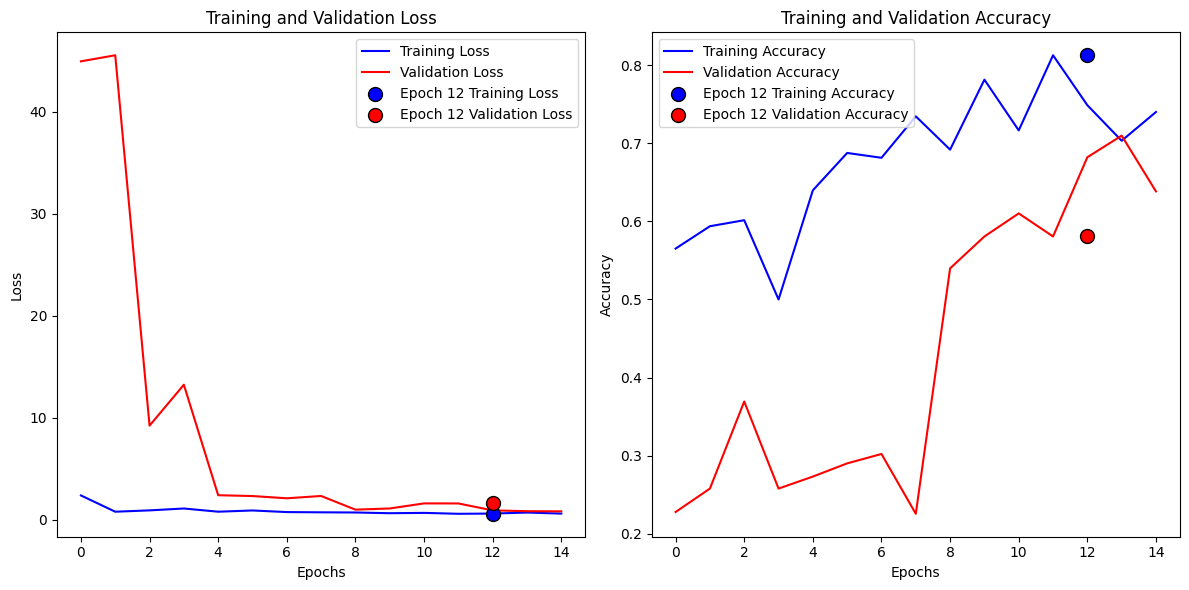

In [ ]:
# Index for Epoch 12 (zero-based index, so 11 for Epoch 12)
epoch_index = 11

# Extract metrics for Epoch 12
epoch_12_loss = history.history['loss'][epoch_index]
epoch_12_val_loss = history.history['val_loss'][epoch_index]
epoch_12_accuracy = history.history['accuracy'][epoch_index]
epoch_12_val_accuracy = history.history['val_accuracy'][epoch_index]

print(f"Epoch 12 - Training Loss: {epoch_12_loss:.4f}")
print(f"Epoch 12 - Validation Loss: {epoch_12_val_loss:.4f}")
print(f"Epoch 12 - Training Accuracy: {epoch_12_accuracy:.4f}")
print(f"Epoch 12 - Validation Accuracy: {epoch_12_val_accuracy:.4f}")

# Create a figure to plot metrics
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.scatter(epoch_index + 1, epoch_12_loss, color='blue', s=100, edgecolor='black', zorder=5, label='Epoch 12 Training Loss')
plt.scatter(epoch_index + 1, epoch_12_val_loss, color='red', s=100, edgecolor='black', zorder=5, label='Epoch 12 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.scatter(epoch_index + 1, epoch_12_accuracy, color='blue', s=100, edgecolor='black', zorder=5, label='Epoch 12 Training Accuracy')
plt.scatter(epoch_index + 1, epoch_12_val_accuracy, color='red', s=100, edgecolor='black', zorder=5, label='Epoch 12 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 12 - Training Loss: 0.5867
Epoch 12 - Validation Loss: 1.6020
Epoch 12 - Training Accuracy: 0.8125
Epoch 12 - Validation Accuracy: 0.5806


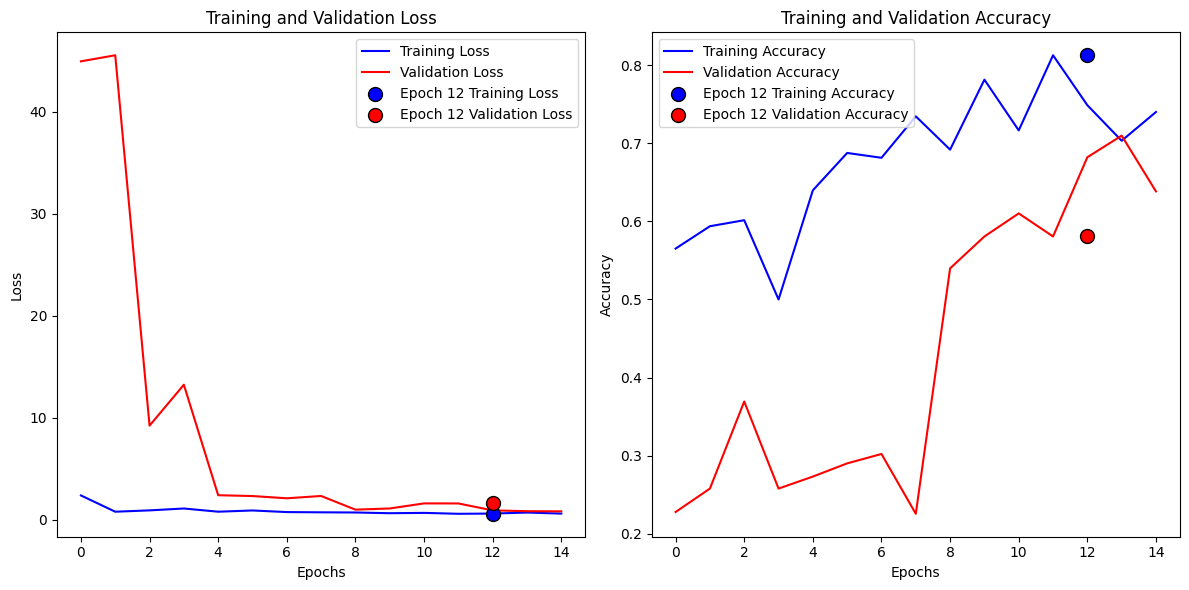

21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6318 - loss: 0.8044
Final Test accuracy: 0.6354, Test loss: 0.8347
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step


<Figure size 800x600 with 0 Axes>

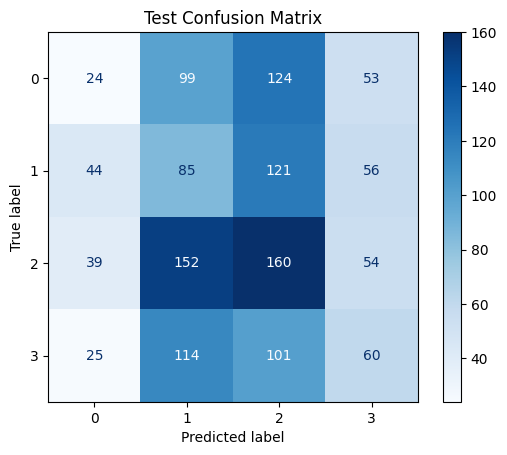

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Index for Epoch 12 (zero-based index, so 11 for Epoch 12)
epoch_index = 11

# Extract metrics for Epoch 12
epoch_12_loss = history.history['loss'][epoch_index]
epoch_12_val_loss = history.history['val_loss'][epoch_index]
epoch_12_accuracy = history.history['accuracy'][epoch_index]
epoch_12_val_accuracy = history.history['val_accuracy'][epoch_index]

print(f"Epoch 12 - Training Loss: {epoch_12_loss:.4f}")
print(f"Epoch 12 - Validation Loss: {epoch_12_val_loss:.4f}")
print(f"Epoch 12 - Training Accuracy: {epoch_12_accuracy:.4f}")
print(f"Epoch 12 - Validation Accuracy: {epoch_12_val_accuracy:.4f}")

# Create a figure to plot metrics
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.scatter(epoch_index + 1, epoch_12_loss, color='blue', s=100, edgecolor='black', zorder=5, label='Epoch 12 Training Loss')
plt.scatter(epoch_index + 1, epoch_12_val_loss, color='red', s=100, edgecolor='black', zorder=5, label='Epoch 12 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.scatter(epoch_index + 1, epoch_12_accuracy, color='blue', s=100, edgecolor='black', zorder=5, label='Epoch 12 Training Accuracy')
plt.scatter(epoch_index + 1, epoch_12_val_accuracy, color='red', s=100, edgecolor='black', zorder=5, label='Epoch 12 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# For confusion matrix, evaluate the model on the test set
# You will get the metrics for the final epoch, but not Epoch 12 if not saved

test_loss, test_acc = cnn.evaluate(test_generator)
print(f'Final Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

# Make predictions on the test set
y_test_pred = np.argmax(cnn.predict(test_generator), axis=1)
y_test_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))], axis=0)

# Calculate and plot the confusion matrix for the test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
n_classes = cm_test.shape[0]  # Determine number of classes from confusion matrix

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.arange(n_classes)).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
